In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import*

In [3]:
mpl.rcParams['font.size'] = 16

In [4]:
A=np.array([[1.1,1],
          [0,1]])
nx=A.shape[1]
print(A)
print('A.shape ={}'.format(A.shape))

[[1.1 1. ]
 [0.  1. ]]
A.shape =(2, 2)


In [5]:
B=np.array([[0.5],[1]])
nu=B.shape[1]
print(B)
print('B.shape ={}'.format(B.shape))

[[0.5]
 [1. ]]
B.shape =(2, 1)


In [6]:
x=SX.sym("x",nx,1)
u=SX.sym("u",nu,1)
w=SX.sym("w",2,1)

In [7]:
x_next=A@x + B@u +w

system = Function("sys",[x,u,w],[x_next])

print(x_next)

[((((1.1*x_0)+x_1)+(0.5*u))+w_0), ((x_1+u)+w_1)]


In [8]:
x0=np.ones((2,1))
u0=np.ones((1,1))
w_k=np.array([[0.25,0.25,-0.25,-0.25],[0.25,-0.25,0.25,-0.25]]).reshape(2,4)
x_next=system(x0,u0,w_k[:,1])
print(w_k[:,1])
print(x_next)

[ 0.25 -0.25]
[2.85, 1.75]


In [9]:
N=10
n_robust=1
N_cases=w_k.shape[1]
x_0 = np.array([2,1]).reshape(2,1)
u_k =np.array([0.5]).reshape(1,1)
res_x=[x_0]
N=N-n_robust

In [10]:
for i in range(N_cases):
    w = np.random.uniform(low=-0.25, high=0.25, size=(2,1))
    x_j_k =  system(x_0,u_k,w)
    res_x.append(x_j_k)
    x_0 = x_j_k
    
res_x = np.concatenate(res_x,axis=1)
print(res_x)

[[ 2.          3.22658288  5.44839122  8.69420145 12.5139674 ]
 [ 1.          1.70723461  2.3012654   2.8607687   3.56278911]]


Text(0.5, 0, 'time')

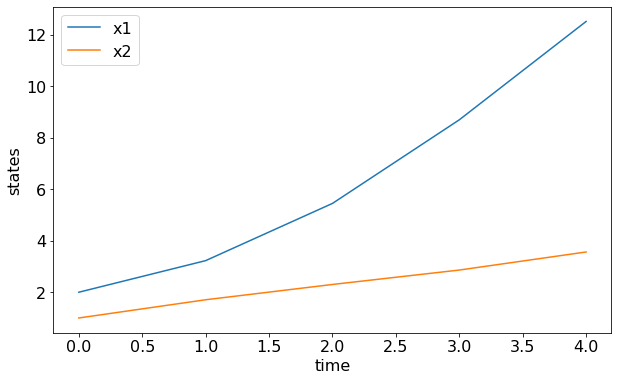

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
lines = ax.plot(res_x.T)
ax.legend(lines, ['x1','x2'])

# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

In [12]:
Q = 1
Q = Q*np.diag(np.ones(nx))
print(Q)

[[1. 0.]
 [0. 1.]]


In [13]:
R = 0.1
R = np.diag(R*np.ones(nu))
print(R)

[[0.1]]


In [14]:
# stage cost
stage_cost = x.T@Q@x+ u.T@R@u
stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

# terminal cost
terminal_cost = x.T@Q@x
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

In [15]:
# state constraints
lb_x = -2*np.ones((nx,1))
ub_x = 2*np.ones((nx,1))
# input constraints
lb_u = -1*np.ones((nu,1))
ub_u = 1*np.ones((nu,1))

In [16]:
J = 0
X=[]
U=[]
lb_X = [] # lower bound for X.
ub_X = [] # upper bound for X
lb_U = [] # lower bound for U
ub_U = [] # upper bound for U
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g
g1 = []    # constraint expression g
lb_g1 = []  # lower bound for constraint expression g
ub_g1 = []
g2 = []    # constraint expression g
lb_g2 = []  # lower bound for constraint expression g
ub_g2 = []


In [17]:
x_0=SX.sym("X",nx,1)
X.append(x_0)
for i in range (N_cases):
        x_case=SX.sym("X",(N+1)*nx,1)
        u_case=SX.sym("U",(N+1)*nu,1)
        X.append(x_case)
        U.append(u_case)

print(X)
print(len(X))
print(U)

[SX([X_0, X_1]), SX([X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_17, X_18, X_19]), SX([X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_17, X_18, X_19]), SX([X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_17, X_18, X_19]), SX([X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9, X_10, X_11, X_12, X_13, X_14, X_15, X_16, X_17, X_18, X_19])]
5
[SX([U_0, U_1, U_2, U_3, U_4, U_5, U_6, U_7, U_8, U_9]), SX([U_0, U_1, U_2, U_3, U_4, U_5, U_6, U_7, U_8, U_9]), SX([U_0, U_1, U_2, U_3, U_4, U_5, U_6, U_7, U_8, U_9]), SX([U_0, U_1, U_2, U_3, U_4, U_5, U_6, U_7, U_8, U_9])]


In [18]:
for i in range(N_cases):
    x_k =X[0][0*nx:(0+1)*nx,:]
    x_k_next = X[i+1][(0)*nx:(0+1)*nx,:]
    u_k = U[0][0*nu:(0+1)*nu,:]
    J += stage_cost_fcn(x_k,u_k)
    x_k_next_calc =  system(x_k,u_k,w_k[:,i])
    g.append(x_k_next - x_k_next_calc)
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    lb_U.append(lb_u)
    ub_U.append(ub_u)
    for k in range(9):
        
        x_k =X[i+1][k*nx:(k+1)*nx,:]
        x_k_next = X[i+1][(k+1)*nx:(k+2)*nx,:]
        u_k = U[i][(k+1)*nu:(k+2)*nu,:]
        
        J += stage_cost_fcn(x_k,u_k)
        
        x_k_next_calc =  system(x_k,u_k,w_k[:,i])
        
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
        
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)

    
    x_terminal = X[i+1][N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal)
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    if(i!=N_cases-1):
        g1.append(U[i][0*nu:(0+1)*nu,:]- U[i+1][0*nu:(0+1)*nu,:])
        lb_g1.append(np.zeros((nu,1)))
        ub_g1.append(np.zeros((nu,1)))


In [19]:
lb_X.append(lb_x)
ub_X.append(ub_x)



In [20]:

lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(*X,*U)
g = vertcat(*g,*g1)
lbg = vertcat(*lb_g,*lb_g1)
ubg = vertcat(*ub_g,*lb_g1)

prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

In [21]:
print(lbg.shape)
print(ubg.shape)
print(g.shape)

(83, 1)
(83, 1)
(83, 1)


In [22]:
x_0 = np.array([1,-1]).reshape(2,1)

In [23]:
lbx[:nx]=x_0
ubx[:nx]=x_0


In [24]:
res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
print(res)
print(res['x'].shape)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      274
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      117

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equa

In [37]:
X = res['x'][:(N_cases*(N+1)*nx)+nx].full().reshape((N_cases*(N+1))+nu, nx)
U = res['x'][(N_cases*(N+1)*nx)+nx:].full().reshape((N_cases*(N+1), nu))
print((N_cases*(N+1)*nx)+nx)
print(N_cases*(N+1))
nX=len(lb_X)
nU=len(lb_U)
print(nX)
print(nU)

82
40
41
40


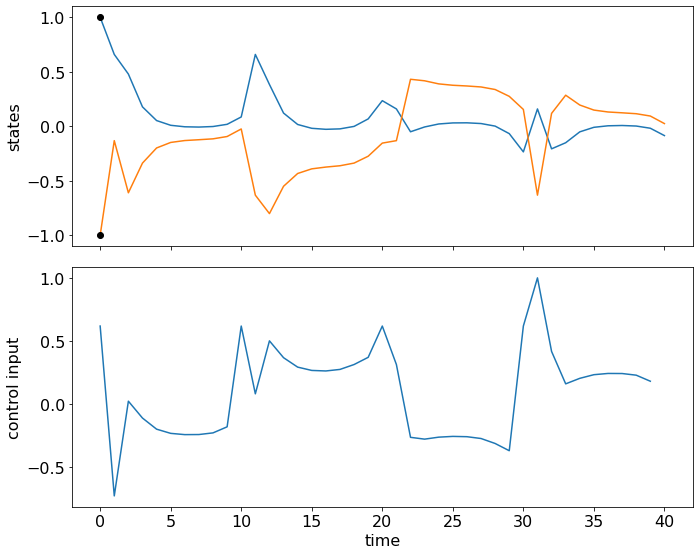

In [26]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(X)
ax[1].plot(U)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

In [27]:
x_0 = np.array([2,-2]).reshape(2,1)
res_x = [x_0]
res_u = []
print(x_0)
N_sim = 50
w = 0.15*np.ones((2,1))
print(x_0)

[[ 2]
 [-2]]
[[ 2]
 [-2]]


In [28]:
for i in range(N_sim):
    # fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    # solve optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    # u_k = res['x'][(N_cases*(N+1))*nx:(N_cases*(N+1))*nx+nu,:]
    u_k=res['x'][(N_cases*(N+1)*nx)+nx:(N_cases*(N+1))*nx+nx+nu,:]
    res_u.append(u_k)
    # simulate the system
    x_next = system(x_0,u_k,w)
    print(x_0)
    
    res_x.append(x_next)
    x_0 = x_next
    
# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)
res_u = np.concatenate(res_u, axis=1)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      274
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      117

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:       83
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:       83
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.7405685e-001 6.27e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8038713e+000 1.11e-016 8.12e-001  -1.0 9.01e-001    -  5.50e-001 1.00e+000h  1
   2 6.6806499e+000 2.22e-016 3.06e-002  -1.7 7.52e-002    -  9.51e-001 1.00e+000f  1
   3 6.6368285e+000 1.67e-016 3.09e-016  -2.5 8.34e-002    -  1.00e+000 1.00e+000f  1
   4 6.6293634e+000 8.33e-017 6.18e-016  -3.8 2.39e-002    -  

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.7346670e-001 6.27e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8029507e+000 1.11e-016 8.12e-001  -1.0 9.01e-001    -  5.50e-001 1.00e+000h  1
   2 6.6797213e+000 1.39e-016 3.06e-002  -1.7 7.52e-002    -  9.51e-001 1.00e+000f  1
   3 6.6358976e+000 1.11e-016 6.25e-016  -2.5 8.34e-002    -  1.00e+000 1.00e+000f  1
   4 6.6284319e+000 1.11e-016 7.42e-016  -3.8 2.39e-002    -  1.00e+000 1.00e+000f  1
   5 6.6269416e+000 1.11e-016 2.49e-005  -5.7 5.07e-003    -  9.98e-001 1.00e+000f  1
   6 6.6268680e+000 1.11e-016 1.17e-015  -5.7 2.48e-004    -  1.00e+000 1.00e+000f  1
   7 6.6268660e+000 1.11e-016 1.25e-015  -8.6 7.28e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
O

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      274
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      117

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:       83
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.7339776e-001 6.27e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+00

[0.451566, -0.120157]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      274
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      117

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:       83
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:       83
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.7339698e-001 6.27e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8028420e+000 1.11e-016 8.12e-001  -1.0 9.01e-001    -  5.50e-001 1.00e+000h  1
   2 6.6796116e+000 1.11e-016 3.06e-002  -1.7 7.52e-002    -  9.51e-001 1.00e+000f  1
   3 6.6357876e+000 1.11e-016 6.80e-016  -2.5 8.34e-002    -  1.00e+000 1.00e+000f  1
   4 6.6283218e+000 1.11e-016 8.08e-016  -3.8 2.39e-002    -  

Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |  14.00ms ( 14.00ms)  14.00ms ( 14.00ms)         1
[0.451566, -0.120157]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE

   1 6.8028420e+000 1.11e-016 8.12e-001  -1.0 9.01e-001    -  5.50e-001 1.00e+000h  1
   2 6.6796116e+000 1.11e-016 3.06e-002  -1.7 7.52e-002    -  9.51e-001 1.00e+000f  1
   3 6.6357876e+000 1.11e-016 1.96e-015  -2.5 8.34e-002    -  1.00e+000 1.00e+000f  1
   4 6.6283218e+000 1.11e-016 8.44e-016  -3.8 2.39e-002    -  1.00e+000 1.00e+000f  1
   5 6.6268315e+000 1.11e-016 2.49e-005  -5.7 5.07e-003    -  9.98e-001 1.00e+000f  1
   6 6.6267579e+000 1.11e-016 5.11e-016  -5.7 2.48e-004    -  1.00e+000 1.00e+000f  1
   7 6.6267559e+000 1.11e-016 4.59e-016  -8.6 7.28e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.6267558500935628e+000   6.6267558500935628e+000
Dual infeasibility......:  4.5875219719998181e-016   4.5875219719998181e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  2.6742623413061036e-009   2.67426234130

   4 6.6283218e+000 1.11e-016 5.26e-016  -3.8 2.39e-002    -  1.00e+000 1.00e+000f  1
   5 6.6268315e+000 1.11e-016 2.49e-005  -5.7 5.07e-003    -  9.98e-001 1.00e+000f  1
   6 6.6267579e+000 1.11e-016 9.91e-016  -5.7 2.48e-004    -  1.00e+000 1.00e+000f  1
   7 6.6267559e+000 1.11e-016 3.65e-016  -8.6 7.28e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.6267558500927732e+000   6.6267558500927732e+000
Dual infeasibility......:  3.6486770060102560e-016   3.6486770060102560e-016
Constraint violation....:  1.1102230246251565e-016   1.1102230246251565e-016
Complementarity.........:  2.6742623413051391e-009   2.6742623413051391e-009
Overall NLP error.......:  2.6742623413051391e-009   2.6742623413051391e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:       83
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8.7339698e-001 6.27e-001 0.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.8028420e+000 1.11e-016 8.12e-001  -1.0 9.01e-001    -  5.50e-001 1.00e+000h  1
   2 6.6796116e+000 1.67e-016 3.06e-002  -1.7 7.52e-002    -  9.51e-001 1.00e+000f  1
   3 6.6357876e+000 1.11e-016 3.99e-016  -2.5 8.34e-002    -  1.00e+000 1.00e+000f  1
   4 6.6283218e+000 1.67e-016 3.63e-016  -3.8 2.39e-002    -  

In [29]:
print(res_x)

[[ 2.          0.85        0.49632141  0.4657077   0.45790876  0.45454778
   0.45297475  0.45223185  0.45188067  0.45171464  0.45163615  0.45159904
   0.4515815   0.45157321  0.45156928  0.45156743  0.45156655  0.45156614
   0.45156594  0.45156585  0.45156581  0.45156579  0.45156578  0.45156577
   0.45156577  0.45156577  0.45156577  0.45156577  0.45156577  0.45156577
   0.45156577  0.45156577  0.45156577  0.45156577  0.45156577  0.45156577
   0.45156577  0.45156577  0.45156577  0.45156577  0.45156577  0.45156577
   0.45156577  0.45156577  0.45156577  0.45156577  0.45156577  0.45156577
   0.45156577  0.45156577  0.45156577]
 [-2.         -0.85       -0.17735718 -0.13313452 -0.12560491 -0.1226988
  -0.12135682 -0.12072393 -0.1204248  -0.12028338 -0.12021653 -0.12018492
  -0.12016998 -0.12016291 -0.12015957 -0.12015799 -0.12015725 -0.12015689
  -0.12015673 -0.12015665 -0.12015661 -0.12015659 -0.12015658 -0.12015658
  -0.12015658 -0.12015658 -0.12015658 -0.12015658 -0.12015658 -0.12015658


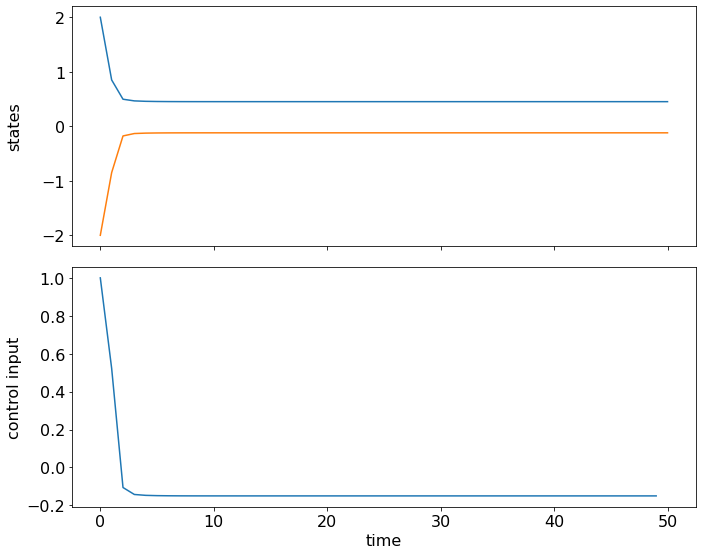

In [30]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x.T)
ax[1].plot(res_u.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()